# Tests ForecasterAutoregMultiseries when series have the same length without NaNs

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.insert(1, str(Path.cwd().parent.parent))
print(str(Path.cwd().parent.parent))

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

set_dark_theme()

# Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import (
    bayesian_search_forecaster_multiseries,
)
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Others
# ==============================================================================
import warnings
import sys

print(f"Python version: {sys.version}")
print(f"skforecast version: {skforecast.__version__}")
print(f"lightgbm version: {lightgbm.__version__}")
print(f"sklearn version: {sklearn.__version__}")

/home/ubuntu/varios/skforecast
Python version: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:29:18) [GCC 11.2.0]
skforecast version: 0.12.0
lightgbm version: 3.3.5
sklearn version: 1.3.2


In [2]:
# Load time series same length
# ==============================================================================
data = pd.read_parquet("../fixtures/sample_building_consumption.parquet")
data = data.asfreq("D")
series = data[["id_1000", "id_1001", "id_1002", "id_1003", "id_1004"]]
exog = data[["sin_day_of_week", "cos_day_of_week", "air_temperature", "wind_speed"]]

end_train = "2016-10-31 23:59:00"
series_train = series.loc[:end_train, :].copy()
exog_train = exog.loc[:end_train, :].copy()
series_test = series.loc[end_train:, :].copy()
exog_test = exog.loc[end_train:, :].copy()

series_dict = series.to_dict(orient="series")
exog_dict = {k: exog for k in series.columns}
series_dict_train = series_train.to_dict(orient="series")
exog_dict_train = {k: exog_train for k in series.columns}
series_dict_test = series_test.to_dict(orient="series")
exog_dict_test = {k: exog_test for k in series.columns}

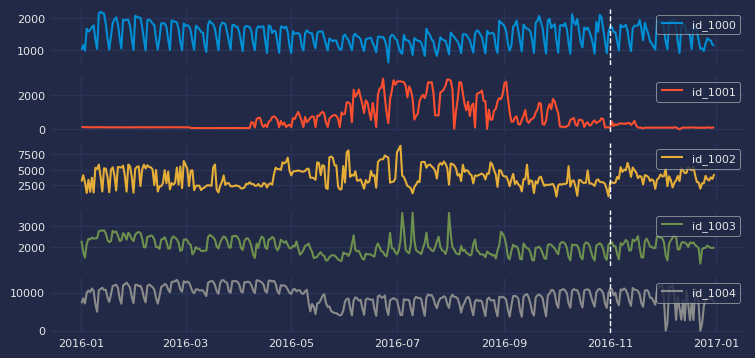

In [3]:
# Plot series
# ==============================================================================
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc="upper right", fontsize=8)
    axs[i].tick_params(axis="both", labelsize=8)
    axs[i].axvline(
        pd.to_datetime(end_train), color="white", linestyle="--", linewidth=1
    )

In [4]:
# Test predictions
# ==============================================================================
params = {
    "encoding": ["ordinal", "onehot", "ordinal_category"],
    "interval": [[5, 95]],
    "n_boot": [10],
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")

    steps = 10
    forecaster = ForecasterAutoregMultiSeries(
        regressor=LinearRegression(),
        lags=14,
        encoding=params["encoding"],
        dropna_from_series=False,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    forecaster.fit(series=series_train, exog=exog_train)
    predictions_1 = forecaster.predict(steps=steps, exog=exog_test)
    predictions_1_interval = forecaster.predict_interval(
        steps=steps,
        exog=exog_test,
        interval=params["interval"],
        n_boot=params["n_boot"],
    )

    forecaster.fit(series=series_train, exog=exog_dict_train)
    predictions_2 = forecaster.predict(steps=steps, exog=exog_dict_test)
    predictions_2_interval = forecaster.predict_interval(
        steps=steps,
        exog=exog_dict_test,
        interval=params["interval"],
        n_boot=params["n_boot"],
    )

    forecaster.fit(series=series_dict_train, exog=exog_dict_train)
    predictions_3 = forecaster.predict(steps=steps, exog=exog_dict_test)
    predictions_3_interval = forecaster.predict_interval(
        steps=steps,
        exog=exog_dict_test,
        interval=params["interval"],
        n_boot=params["n_boot"],
    )

    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)
    pd.testing.assert_frame_equal(predictions_1_interval, predictions_2_interval)
    pd.testing.assert_frame_equal(predictions_1_interval, predictions_3_interval)

Paramns: {'encoding': 'ordinal', 'interval': [5, 95], 'n_boot': 10}


Paramns: {'encoding': 'onehot', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'encoding': 'ordinal_category', 'interval': [5, 95], 'n_boot': 10}


In [5]:
# Test backtesting
# ==============================================================================
params = {
    "initial_train_size": [50, len(series_train)],
    "refit": [True, False, 2],
    "fixed_train_size": [True, False],
    "gap": [0, 7],
    "levels": [
        None,
        ["id_1000", "id_1001", "id_1002", "id_1003", "id_1004"],
        "id_1000",
        ["id_1000", "id_1001"],
    ],
    "metrics": [["mean_absolute_error", "mean_squared_error"], "mean_absolute_error"],
    "allow_incomplete_fold": [True, False],
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")

    forecaster = ForecasterAutoregMultiSeries(
        regressor=LinearRegression(),  # LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog,
        levels=params["levels"],
        steps=24,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog_dict,
        levels=params["levels"],
        steps=24,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series_dict,
        exog=exog_dict,
        levels=params["levels"],
        steps=24,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    pd.testing.assert_frame_equal(
        metrics_1,
        metrics_2,
    )
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['i

In [6]:
# Test backtesting with intervals
# ==============================================================================
params = {
    "initial_train_size": [50, len(series_train)],
    "refit": [True, False, 2],
    "fixed_train_size": [True, False],
    "gap": [0, 7],
    "levels": [
        None,
        ["id_1000", "id_1001", "id_1002", "id_1003", "id_1004"],
        "id_1000",
        ["id_1000", "id_1001"],
    ],
    "metrics": [["mean_absolute_error", "mean_squared_error"], "mean_absolute_error"],
    "allow_incomplete_fold": [True, False],
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")

    forecaster = ForecasterAutoregMultiSeries(
        regressor=LinearRegression(),  # LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog,
        levels=params["levels"],
        steps=24,
        interval=[5, 95],
        n_boot=5,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog_dict,
        levels=params["levels"],
        steps=24,
        interval=[5, 95],
        n_boot=5,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series_dict,
        exog=exog_dict,
        levels=params["levels"],
        steps=24,
        interval=[5, 95],
        n_boot=5,
        metric=params["metrics"],
        initial_train_size=params["initial_train_size"],
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
        n_jobs="auto",
        verbose=False,
        show_progress=False,
    )

    pd.testing.assert_frame_equal(metrics_1, metrics_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_tra

In [7]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

lags_grid = [[5], [1, 7, 14]]


def search_space(trial):
    search_space = {
        "n_estimators": trial.suggest_int("n_estimators", 2, 5),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "lags": trial.suggest_categorical("lags", lags_grid),
    }

    return search_space


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog,
        search_space=search_space,
        metric="mean_absolute_error",
        initial_train_size=len(series_train),
        steps=10,
        refit=False,
        n_trials=3,
        return_best=False,
        show_progress=False,
        verbose=False,
    )

    results_search_2, best_trial_2 = bayesian_search_forecaster_multiseries(
        forecaster=forecaster,
        series=series,
        exog=exog_dict,
        search_space=search_space,
        metric="mean_absolute_error",
        initial_train_size=len(series_train),
        steps=10,
        refit=False,
        n_trials=3,
        return_best=False,
        show_progress=False,
        verbose=False,
    )

    results_search_3, best_trial_3 = bayesian_search_forecaster_multiseries(
        forecaster=forecaster,
        series=series_dict,
        exog=exog_dict,
        search_space=search_space,
        metric="mean_absolute_error",
        initial_train_size=len(series_train),
        steps=10,
        refit=False,
        n_trials=3,
        return_best=False,
        show_progress=False,
        verbose=False,
    )

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

Number of models compared: 3,
         3 bayesian search in each lag configuration.
[LightGBM] [Warning] Unknown parameter: lags
Number of models compared: 3,
         3 bayesian search in each lag configuration.
Number of models compared: 3,
         3 bayesian search in each lag configuration.


In [8]:
# Test Grid Search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
)

lags_grid = [[5], [1, 7, 14]]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}


results_search_1 = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series,
    exog=exog,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric="mean_absolute_error",
    initial_train_size=len(series_train),
    steps=10,
    refit=False,
    return_best=False,
    show_progress=False,
    verbose=False,
)


results_search_2 = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series,
    exog=exog_dict,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric="mean_absolute_error",
    initial_train_size=len(series_train),
    steps=10,
    refit=False,
    return_best=False,
    show_progress=False,
    verbose=False,
)

results_search_3 = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric="mean_absolute_error",
    initial_train_size=len(series_train),
    steps=10,
    refit=False,
    return_best=False,
    show_progress=False,
    verbose=False,
)

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.


In [9]:
# Last execution
# ==============================================================================
print(f"Last execution: {pd.Timestamp.now()}")

Last execution: 2024-04-11 10:48:50.183240
